In [96]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [135]:
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.gbm import GBM
from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModel 


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
np.random.seed(42)
n = 365
T = 1.
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 1 yr horizon
model = GBM(drift = 0.05, volatility=0.25)
n_sims = 100
S0 = 0.2
paths = model.simulate(timegrid, start_value=S0,M = n_sims, n=n)


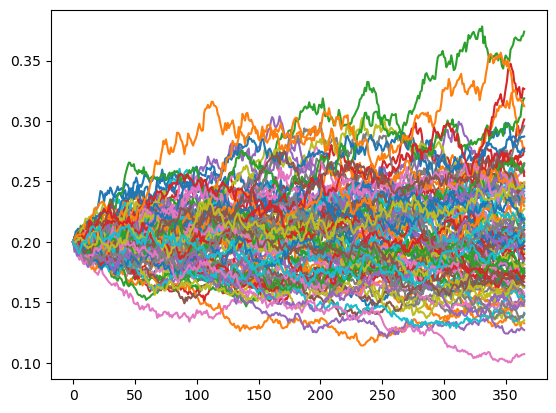

In [153]:
plt.plot(paths)

In [154]:
refdate = dt.datetime(2023,1,1)
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=365)
strike = 0.2
spec = EuropeanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',
                                                       share_ratio = 1)

In [155]:
pricing_result =  VanillaOptionDeepHedgingPricer.price(refdate, 
                                      spec, 
                                      model,
                                      depth=3, 
                                      nb_neurons=64, 
                                      n_sims=100_000, 
                                      regularization=0.0,
                                      epochs=1, verbose=1,
                                      tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                      initial_lr=5e-4,
                                      decay_steps=8_000,
                                      batch_size=100, decay_rate=0.8, seed=42)

(<tf.Tensor 'IteratorGetNext:0' shape=(100, 366) dtype=float32>,)
(<tf.Tensor 'IteratorGetNext:0' shape=(100, 366) dtype=float32>,)


In [150]:
pnl = pricing_result.hedge_model.compute_pnl(pricing_result.paths, pricing_result.payoff)
inputs = pricing_result.hedge_model._create_inputs(pricing_result.paths)
loss = pricing_result.hedge_model.evaluate(inputs, pricing_result.payoff)
#delta = pricing_result.hedge_model.compute_delta(pricing_result.paths)

test = {'mean': pnl.mean(), 'var': pnl.var(), 
            'loss': loss,
            '1%':np.percentile(pnl,1), '99%': np.percentile(pnl,99),
            '5%':np.percentile(pnl,5), '95%': np.percentile(pnl,95)}

(<tf.Tensor 'IteratorGetNext:0' shape=(32, 366) dtype=float32>,)
  69/3125 [..............................] - ETA: 3:58

KeyboardInterrupt: 

In [143]:
print(pnl)

[119.90918703 119.74752162 119.97619644 ... 119.89280883 119.82067726
 119.79942454]


Text(0.5, 0, 'PnL')

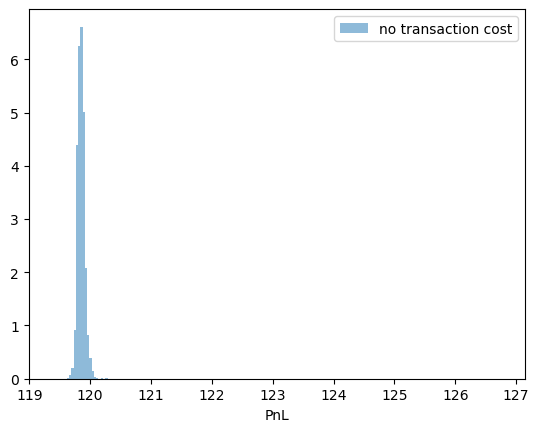

In [144]:
plt.hist(pnl, bins=200, label='no transaction cost', density=True, alpha=0.5)
plt.legend()
plt.xlabel('PnL')